### <img src="https://www.dropbox.com/s/l93ecugg1jbtjiw/fga.png?raw=1" width="1200" height="400">

<ul>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b></li> 
    <li>
     Prof. Marcelino Monteiro de Andrade Dr.</li>
</ul> 
    
    Segunda (2/3) Atividade Prática Avaliativa - Algo Trading
    Entrega da Atividade 31/08/2022 
    "A não entrega na data esperada reduz em 50% na nota da avaliação"


<div id="Tópicos">
<h2>Questões</h2>
&ensp;
    <ol> 
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na primeira avaliação, considere um capital de R$\100.000,00 e as taxas envolvidas na operação.</a></li>&ensp;
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis anteriores, adicionando à aplicação o RSI ou MACD. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Escolha uma estratégia de trade automático de contra tendência, apresentada na Referência Palex. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aplique nos ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Compare os resultados das três estratégias de trades, quanto: a) Retorno de Capital, b) Número de Trades, c) Taxa de Acertos, d) Fator de Lucro, e) Índice Sharpe e o f) retorno dos ativos avaliados na condição buy&hold e com relação ao índice bovespa.</a></li>&ensp;
        <li>Observação: caso a equipe tenha o interesse em avaliar outras estratégias de algo trading e bem vindo também!</a></li>&ensp;        
</ol>
</div>



In [12]:
%pip install yfinance
%pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import math 
import pandas as pd
%matplotlib inline 
import seaborn as sns
from tqdm import tqdm
import investpy
import matplotlib.dates as mdates
from scipy import signal

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)

In [33]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 100

100%|█████████████████████████████████████████████| 7/7 [00:07<00:00,  1.04s/it]


<AxesSubplot:xlabel='Date'>

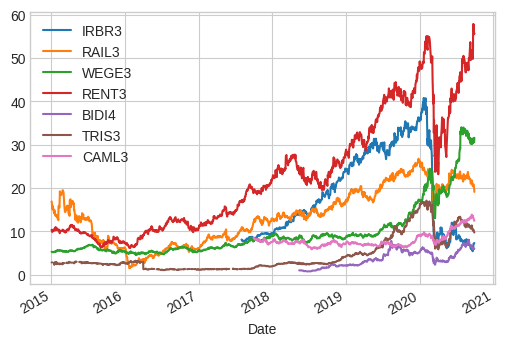

In [83]:
stocks=['IRBR3','RAIL3','WEGE3','RENT3','BIDI4','TRIS3','CAML3']

out = None

for stk in tqdm(stocks):

    df = investpy.get_stock_historical_data(stock=stk,
                                            country='Brazil',
                                            from_date='01/01/2015',
                                            to_date='29/09/2020')

    if out is None:
        out=df["Close"]
    else:
        out=pd.concat([out,df["Close"]],axis=1)
out.columns=stocks
out.tail()
out.plot()

In [85]:
def bollinger_bands(data, trend_periods=21, deviation=2, close_col='Close'):

    data['bol_bands_middle'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    for index, row in data.iterrows():
        s = data[close_col].iloc[index - trend_periods: index]
        sums = 0
        middle_band = data.at[index, 'bol_bands_middle']
        for e in s:
            sums += np.square(e - middle_band)

        std = np.sqrt(sums / trend_periods)
   #     d = 2
        upper_band = middle_band + (deviation * std)
        lower_band = middle_band - (deviation * std)

      #  data.set_value(index, 'bol_bands_upper', upper_band)
        data.at[index, 'bol_bands_upper']=upper_band

     #   data.set_value(index, 'bol_bands_lower', lower_band)
        data.at[index, 'bol_bands_lower']=lower_band



    return data

def crossover_sinal(data):
    #criando MEDIA MOVEL 21 e sinais de compra e venda
    periods = 21
    data['MM21'] = data['Close'].rolling(periods).mean()
    
    data=data.set_index('Date')
    # Sinal de Entrada
    data['signal']=0
    signal=np.zeros(len(data['signal']))
    buy=0
    #se a anterior for negativa e a atual for positiva e um sinal de compra caso contrario e venda
    for day in range(0,len(data)):
        cond1_buy=(data['MM21'].iloc[day])>abs(data['Close'].iloc[day]-data['MM21'].iloc[day]+data['MM21'].iloc[day]*0.1) and (data['Close'].iloc[day]<data['bol_bands_lower'].iloc[day])
        cond1_sell=(data['MM21'].iloc[day])<abs(data['Close'].iloc[day]-data['MM21'].iloc[day]+data['MM21'].iloc[day]*0.1) and (data['Close'].iloc[day]>data['bol_bands_upper'].iloc[day])

        if cond1_buy:
            buy = 1
        if (buy == True) & cond1_sell:
            buy = 0
        signal[day]=buy
        
    data['signal']=signal

    columns = ['Close', 'bol_bands_upper', 'bol_bands_middle', 'bol_bands_lower', 'signal']

    return data[columns]

In [86]:
trades = pd.DataFrame(index=out.index)
trades['Close'] = out['WEGE3'].values

trades.reset_index(inplace=True)

trades = bollinger_bands(trades)

trades = trades.set_index('Date')
trades = crossover_sinal(trades)


trades['positions'] = trades['signal'].diff()



print('positions =', trades['positions'])

fig = plt.subplots(figsize=(20,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(211)
ax1.plot( trades.Close, 'y', label = 'Close')
ax1.plot( trades.bol_bands_middle, 'k:', label = 'middle')
ax1.plot( trades.bol_bands_upper, 'm', label = 'upper')
ax1.plot( trades.bol_bands_lower, 'g', label = 'lower')

ax1.plot(trades.loc[trades.positions == 1.0].index, 
         trades.bol_bands_lower[trades.positions == 1.0],
         '^', markersize=10, color='m',label='Buy')
ax1.plot(trades.loc[trades.positions == -1.0].index, 
         trades.bol_bands_middle[trades.positions == -1.0],
         'v', markersize=10, color='k',label='Sell') 

ax1.set_ylabel("Preço [R$]",fontsize=25)
ax1.set_xlabel("Data",fontsize=25)
ax1.set_title("Médias",fontsize=25)
ax1.legend(loc='upper left',fontsize=25)



trades['Close_recorte']=trades['Close']*trades['signal']

#trades['Close_recorte'][trades['Close_recorte']==0]=16

ax3 = plt.subplot(413)
ax3.plot(trades['Close_recorte'], label='Close')
ax3.set_ylabel("Preço [R$]",fontsize=25)
ax3.set_xlabel("Data",fontsize=25)
ax3.set_title("Médias",fontsize=25)
ax3.legend(loc='upper left',fontsize=25)



ax5 = plt.subplot(414)
pos_buy=np.where(trades['positions']==1)
pos_sell=trades['positions']==-1
days_buy=trades['Close'][trades['positions']==1].index
days_sell=trades['Close'][trades['positions']==-1].index
print('days_buy = ', days_buy)
print('days_sell = ', days_sell)
distance=days_sell-days_buy
buy_trade=[]
for i in range(len(days_buy)):
    values_2=trades['Close'][trades['Close'].index==(days_buy[i]+distance[i])].values[0]
    values_1=trades['Close'][trades['Close'].index==days_buy[i]].values[0]
    buy_trade.append(100*(values_2-values_1)/values_1)
values = np.array(buy_trade)   
values3=buy_trade
plt.ylabel('Retorno [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)


idx = np.array(list(range(len(buy_trade)))) 
clrs = ['red' if (x < 0) else 'blue' for x in values]
sns.barplot(x=idx, y=values, palette=clrs) 
ax52 = ax5.twinx()
ax52.plot(sumper(values),'gold',linewidth=4)

plt.ylabel('Retorno Acumulado [%]',fontsize=25)
plt.xlabel('Trades',fontsize=25)
plt.title('Retornos',fontsize=25)

plt.tight_layout() 



KeyError: "None of ['Date'] are in the columns"

In [18]:
#data set filtrado
filter_data = output_df.loc[(output_df.index < '2020-12-01') & (output_df.index < '2019-01-01')]

Text(0.5, 0, 'Data')

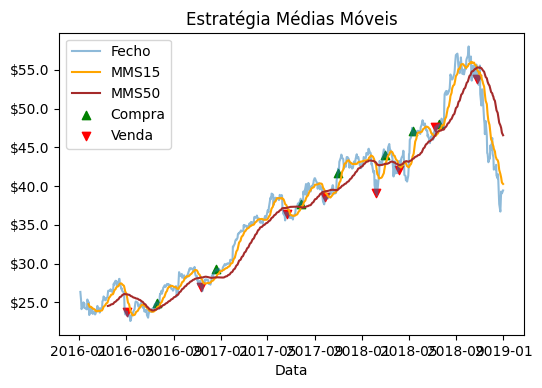

In [19]:
fig= plt.subplot()
ax = plt.subplot()

#Adiciona Informação
ax.plot(filter_data.index,filter_data['Close'],label='Fecho',alpha=0.5)
ax.plot(filter_data.index,filter_data['SMA15'],label='MMS15',color='orange')
ax.plot(filter_data.index,filter_data['SMA50'],label='MMS50',color='brown')

#Adiciona Venda e Compra
ax.scatter(filter_data.index,filter_data['Compra'],label='Compra',marker='^',color='green')
ax.scatter(filter_data.index,filter_data['Venda'],label='Venda',marker='v',color='red')

#formata

ax.legend()

#Labels adicionais
ax.yaxis.set_major_formatter('${x:}')
ax.set_title('Estratégia Médias Móveis')
ax.set_xlabel('Data')